<a href="https://colab.research.google.com/github/Ankit-exe/Anime-Character-Generator/blob/main/Anime_character.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from PIL import Image
import cv2

import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
from google.colab import files
from torch.utils.data import Dataset, DataLoader

In [35]:
# Setting seed
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42)

In [36]:
# Configuration
IMAGE_SIZE = 64
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EPOCHS = 20
NOISE_DIM = 100
num_examples_to_generate = 9
LEARNING_RATE = 0.0002
GENERATOR_LR = 0.0005
DISCRIMINATOR_LR = 0.0002

# It is good to have higher lr for the generator than discriminator because we dont want out discriminator to be so good

In [37]:
# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print(f"GPU NAME: {torch.cuda.get_device_name(0)}")

GPU NAME: Tesla T4


In [38]:
!pip install opendatasets

In [39]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/splcher/animefacedataset")

Skipping, found downloaded files in "./animefacedataset" (use force=True to force download)


In [40]:
# DATASET PATH
DATASET_PATH = "animefacedataset/images"

if not os.path.exists(DATASET_PATH):
  print("Dataset not found")
else:
   print("dataset exists")

dataset exists


In [41]:
image_files = []
valid_extensions = ('.jpg','.jpeg','.png','.bmp')

for file in os.listdir(DATASET_PATH):
  if file.lower().endswith(valid_extensions):
    image_files.append(file)

print(f"Total images: {len(image_files)}")
print(f"Sample files:{image_files[:5]}")

Total images: 63565
Sample files:['25232_2009.jpg', '194_2000.jpg', '24058_2008.jpg', '16842_2007.jpg', '19462_2007.jpg']


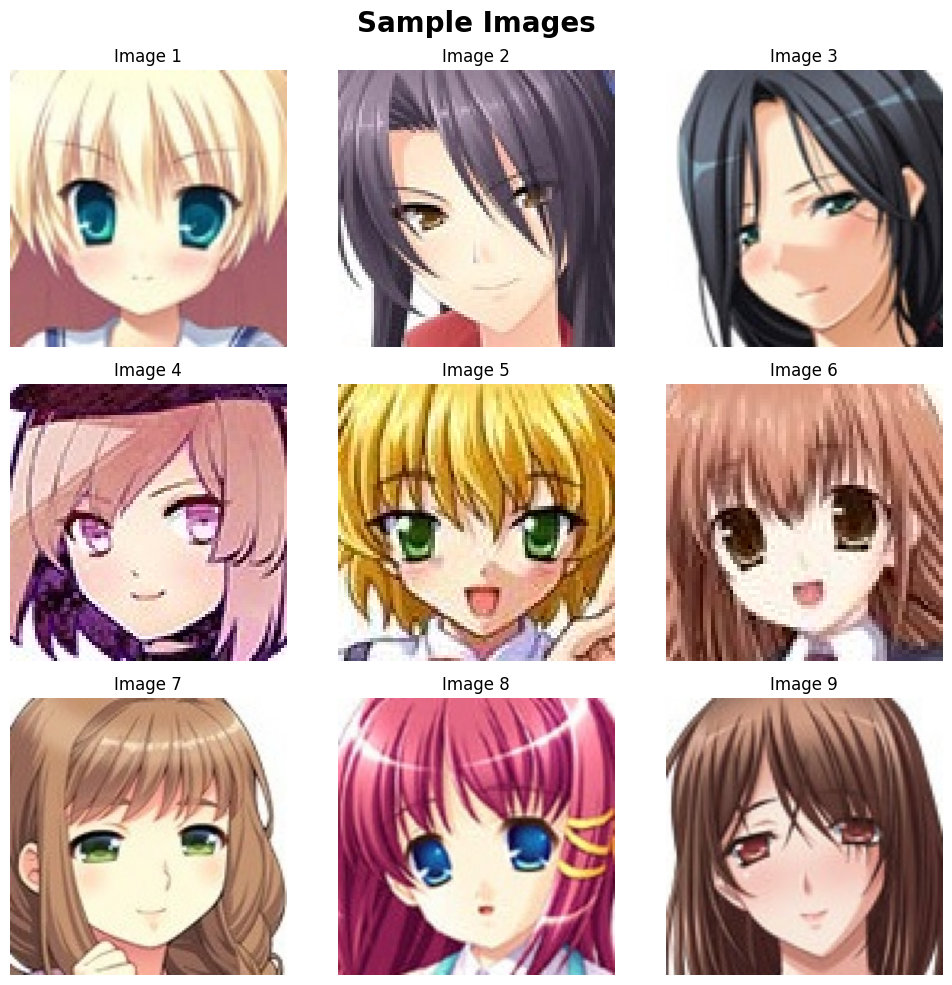

In [42]:
# Visualizing the Dataset

def display_sample_images(image_files,DATASET_PATH,num_samples = 9):
  fig, axes = plt.subplots(3,3,figsize=(10,10))
  fig.suptitle("Sample Images",fontsize=20, fontweight='bold')

  sample_files = np.random.choice(image_files,num_samples,replace=False)

  for i, ax in enumerate(axes.flatten()):
    img_path = os.path.join(DATASET_PATH,sample_files[i])
    try:
      img = Image.open(img_path)
      ax.imshow(img)
      ax.set_title(f"Image {i+1}")

    except Exception as e:
      print(f"Error loading image {img_path}: {e}")
      continue

    ax.axis('off')

  plt.tight_layout()
  plt.show()

display_sample_images(image_files,DATASET_PATH)


In [43]:
# Image properties

def analyze_images(image_files,DATASET_PATH,sample_size = 1000):
  sample_files = np.random.choice(image_files,min(sample_size,len(image_files)),replace=False)

  widths, heights, channels = [],[],[]
  file_sizes = []

  print("Calcuating image properties...")

  for file in tqdm(sample_files[:100]):
    try:
      img_path = os.path.join(DATASET_PATH,file)
      img = Image.open(img_path)

      width, height = img.size
      channel = len(img.getbands())
      file_size = os.path.getsize(img_path)

      widths.append(width)
      heights.append(height)
      channels.append(channel)
      file_sizes.append(file_size)

    except Exception as e:
      print(f"Error loading image {img_path}: {e}")
      continue

  return {
    'width':widths,
    'height':heights,
    'channel':channels,
    'file_size':file_sizes
  }

image_stats = analyze_images(image_files,DATASET_PATH)

Calcuating image properties...


100%|██████████| 100/100 [00:00<00:00, 3781.62it/s]


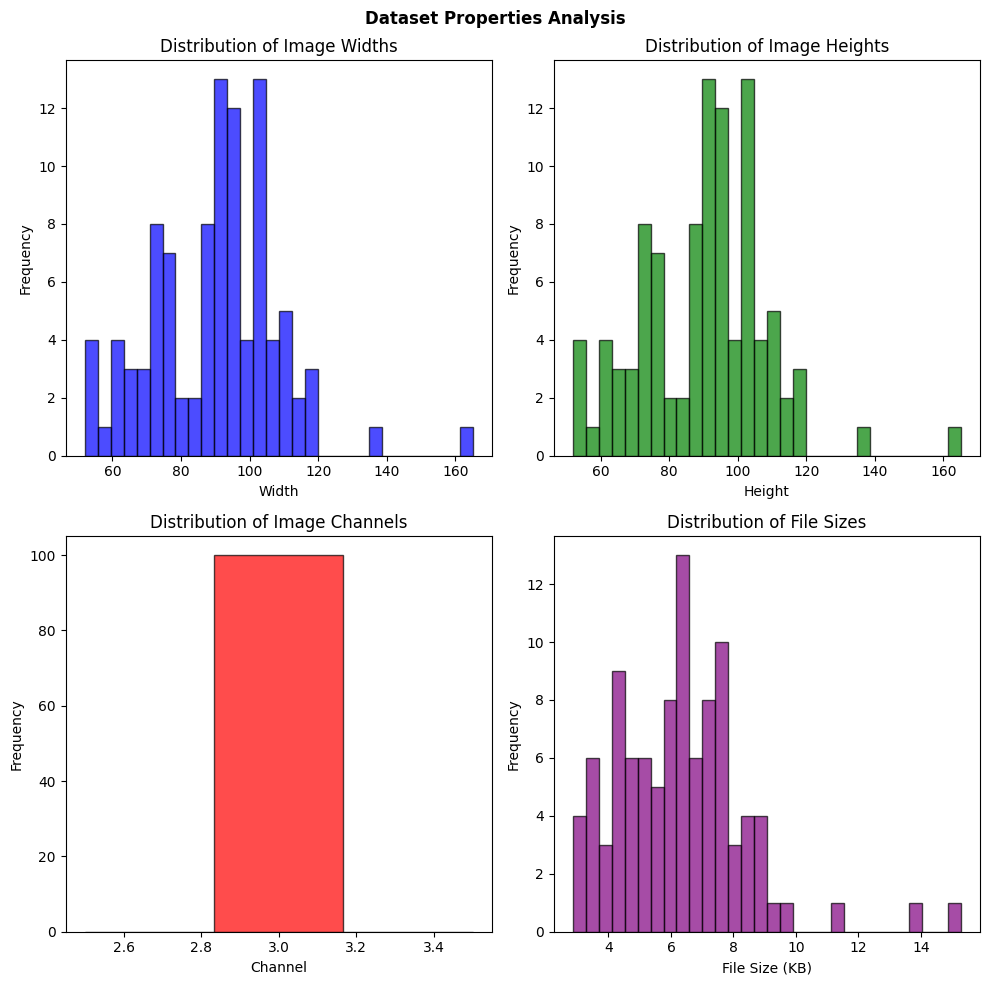

In [44]:
fig ,axes = plt.subplots(2,2, figsize=(10,10))
fig.suptitle("Dataset Properties Analysis", fontweight='bold')

axes[0,0].hist(image_stats['width'],bins=30,alpha =0.7 , color='blue', edgecolor='black')
axes[0,0].set_xlabel('Width')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Image Widths')

axes[0,1].hist(image_stats['height'],bins=30,alpha =0.7 , color='green', edgecolor='black')
axes[0,1].set_xlabel('Height')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Image Heights')

axes[1,0].hist(image_stats['channel'],bins=3  ,alpha =0.7 , color='red', edgecolor='black')
axes[1,0].set_xlabel('Channel')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Image Channels')

axes[1,1].hist([size/1024 for size in image_stats['file_size']], bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1,1].set_xlabel('File Size (KB)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of File Sizes')

plt.tight_layout()
plt.show()

In [45]:
# Print statistics

print(f"Image Statistics:")
print(f"Average width: {np.mean(image_stats['width']):.2f} \xb1 {np.std(image_stats['width']):.2f}")
print(f"Average height: {np.mean(image_stats['height']):.2f} \xb1 {np.std(image_stats['height']):.2f}")
print(f"Number of channels: {max(set(image_stats['channel']))}")
print(f"Average file size: {np.mean(image_stats['file_size'])/1000:.2f}KB")

Image Statistics:
Average width: 89.96 ± 18.47
Average height: 89.96 ± 18.47
Number of channels: 3
Average file size: 6.43KB


In [46]:
# Data Pre-Processing Pipeline

img_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

class AnimeDataset(Dataset):
  def __init__(self,data_path,transform=None):
    self.data_path = data_path
    self.transform = transform
    self.image_files = [f for f in os.listdir(data_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self,idx):
    img_path = os.path.join(self.data_path,self.image_files[idx])
    img = Image.open(img_path).convert('RGB')

    if self.transform:
      img = self.transform(img)
      return img

anime_dataset = AnimeDataset(DATASET_PATH,img_transforms)
print('Dataset Created')

Dataset Created


In [47]:
train_dataloader = DataLoader(anime_dataset, batch_size=BATCH_SIZE,shuffle=True,num_workers=2)

dataset_size = len(anime_dataset)
print(f"Total images in dataset: {dataset_size}")
print(f"Batches per epoch: {len(train_dataloader)}")
print(f"Image shape: {IMAGE_SIZE,IMAGE_SIZE}")
print(f"Batch size:{BATCH_SIZE}")

Total images in dataset: 63565
Batches per epoch: 994
Image shape: (64, 64)
Batch size:64


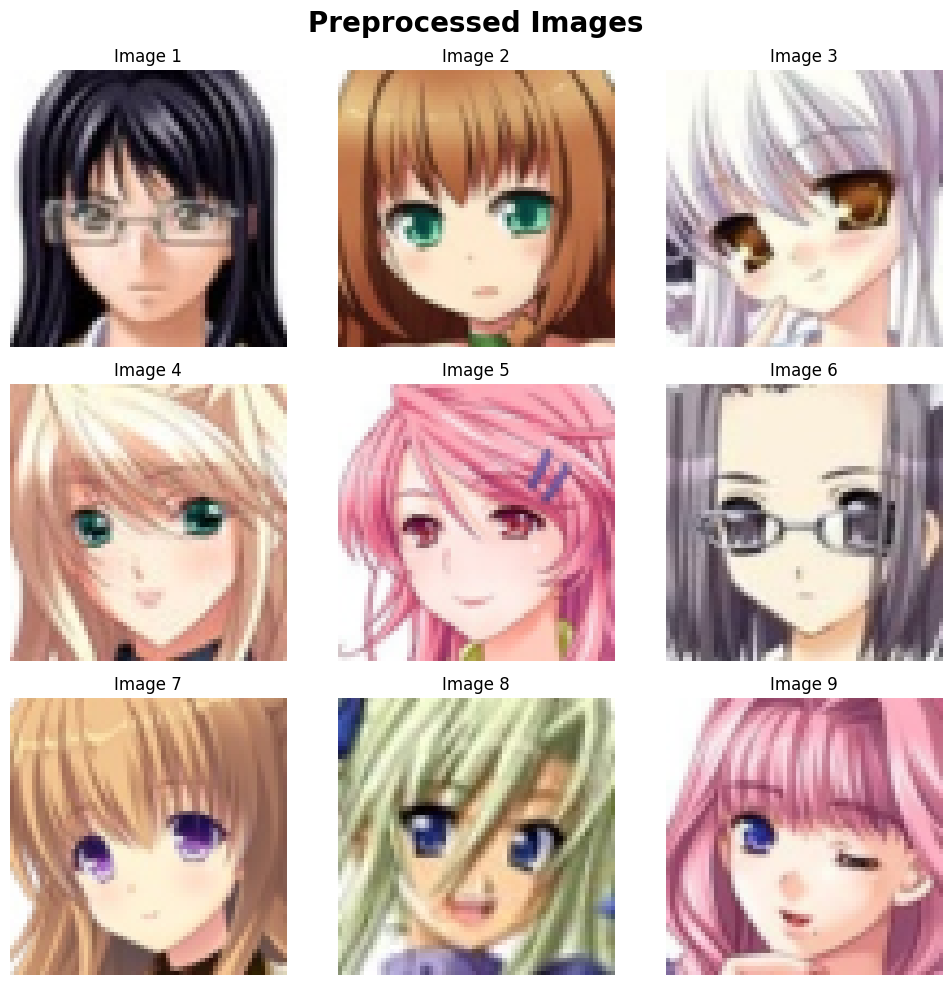

In [48]:
# Visualize PreProcessed Data

def show_preprocessed_batch(dataloader,num_images = 9):
  batch = next(iter(dataloader))
  batch = batch.to(device if device.type!= 'cuda' else 'cpu')
  fig , axes = plt.subplots(3,3,figsize=(10,10))
  fig.suptitle("Preprocessed Images",fontsize=20, fontweight='bold')

  for i, ax in enumerate(axes.flatten()):
    if i<num_images and i<batch.size(0):
      img = batch[i] * 0.5 + 0.5
      img = torch.clamp(img,0.0,1.0)
      ax.imshow(img.cpu().permute(1,2,0).numpy())
      ax.set_title(f"Image {i+1}")
      ax.axis('off')

  plt.tight_layout()
  plt.show()

show_preprocessed_batch(train_dataloader)

In [49]:
# Generator

class Generator(nn.Module):
  def __init__(self, latent_dim=100,img_channels=3, feature_maps=3):
    super(Generator,self).__init__()

    self.main = nn.Sequential(
        nn.ConvTranspose2d(latent_dim,feature_maps*8,4,1,0,bias=False),
        nn.BatchNorm2d(feature_maps*8),
        nn.ReLU(True),

        nn.ConvTranspose2d(feature_maps*8,feature_maps*4,4,2,1,bias=False),
        nn.BatchNorm2d(feature_maps*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(feature_maps*4,feature_maps*2,4,2,1,bias=False),
        nn.BatchNorm2d(feature_maps*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(feature_maps*2,feature_maps,4,2,1,bias=False),
        nn.BatchNorm2d(feature_maps),
        nn.ReLU(True),

        nn.ConvTranspose2d(feature_maps,img_channels,4,2,1,bias=False),
        nn.Tanh()
    )

  def forward(self,x):
    return self.main(x)

generator = Generator(NOISE_DIM).to(device)

In [50]:
# Discriminator

class Discriminator(nn.Module):
  def __init__(self,img_channels=3,feature_maps=64):
    super(Discriminator,self).__init__()

    self.main = nn.Sequential(
      nn.Conv2d(img_channels,feature_maps,4,2,1,bias=False),
      nn.LeakyReLU(0.2,inplace= True),

      nn.Conv2d(feature_maps,feature_maps*2,4,2,1,bias=False),
      nn.BatchNorm2d(feature_maps*2),
      nn.LeakyReLU(0.2,inplace= True),

      nn.Conv2d(feature_maps*2,feature_maps*4,4,2,1,bias=False),
      nn.BatchNorm2d(feature_maps*4),
      nn.LeakyReLU(0.2,inplace= True),

      nn.Conv2d(feature_maps*4,feature_maps*8,4,2,1,bias=False),
      nn.BatchNorm2d(feature_maps*8),
      nn.LeakyReLU(0.2,inplace= True),

      nn.Conv2d(feature_maps*8,1,4,2,0,bias=False),
      nn.Sigmoid()
  )

  def forward(self,x):
    return self.main(x)

discriminator = Discriminator().to(device)

print("Discriminator Architecture")
print(discriminator)

Discriminator Architecture
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (12): Sigmoid()
  )
)


In [51]:
# Loss Function Optimizer

def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data,0.0,0.02)

  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0)

generator.apply(weights_init)
discriminator.apply(weights_init)

# Loss Function

criterion = nn.BCELoss()

# Optimizers
generator_optimizer = optim.Adam(generator.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
discriminator_optimizer = optim.Adam(generator.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))

print("Model initialized successfully!")
print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")

print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

Model initialized successfully!
Generator parameters: 44,682
Discriminator parameters: 2,765,568


In [52]:
# Training setup & Checkpoints

checkpoint_dir = './training_checkpoints'
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
  print("Checkpoint directory created")

fixed_noise = torch.randn(num_examples_to_generate,NOISE_DIM,1,1,device=device)

In [53]:
# Training Function

def generate_and_save_img(model_G,epoch,test_input_noise):
  model_G.eval()

  with torch.no_grad():
    predictions = model_G(test_input_noise).cpu()
  model_G.train()

  fig = plt.figure(figsize=(8,8))
  fig.suptitle(f"Epoch {epoch}",fontsize=20, fontweight='bold')

  for i in range(predictions.shape[0]):
    plt.subplot(4,5,i+1)
    img = predictions[i]*0.5+0.5
    img = torch.clamp(img,0.0,1.0)
    plt.imshow(img.permute(1,2,0).numpy())
    plt.axis('off')

  plt.tight_layout()
  plt.show()

In [54]:
def generate_samples(generator,latent_dim,device,num_samples=16):
  generator.eval()
  with torch.no_grad():
    noise = torch.randn(num_samples,latent_dim,1,1,device=device)
    generated_images = generator(noise)

    displayed_images = (generated_images.cpu() * 0.5 + 0.5).clamp(0.0, 1.0) # Moved to CPU and correct variable

    fig , axes = plt.subplots(4,4,figsize=(10,10))
    fig.suptitle("Generated Images",fontsize=20, fontweight='bold')

    for i in range(num_samples):
            row, col = i // 4, i % 4
            img = displayed_images[i].cpu().permute(1, 2, 0)
            axes[row, col].imshow(img)
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

  generator.train()

In [58]:
def train_gan(dataloader, generator, discriminator,  generator_optimizer, discriminator_optimizer, criterion, noise_dim, fixed_noise, device):
    d_losses = []
    g_losses = []
    d_losses_iter = []
    g_losses_iter = []

    print("Starting Training...")
    print(f"Training for {EPOCHS} epochs with {len(dataloader)} batches per epoch")

    for epoch in range(EPOCHS):
        epoch_g_loss = 0
        epoch_d_loss = 0
        num_batches = 0

        # Progress bar for current epoch
        pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}')

        for i, real_images in enumerate(pbar):
            current_batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Labels - Reshape to match discriminator output
            real_labels = torch.ones(current_batch_size, device=device)
            fake_labels = torch.zeros(current_batch_size, device=device)

            # ---------------------
            # Train Discriminator
            # ---------------------

            # Train with real images
            generator.zero_grad()
            output_real = generator(real_images)
            loss_real = criterion(output_real, real_labels)
            loss_real.backward()
            optimizer._Gste

            # Train with fake images
            noise = torch.randn(current_batch_size, noise_dim, 1, 1, device=device)
            fake_images = generator(noise).detach() # Generate fake images and detach immediately
            output_fake = discriminator(fake_images) # Use detached fake images for D loss
            loss_fake = criterion(output_fake, fake_labels)

            # Total discriminator loss
            loss_D = loss_real + loss_fake
            loss_D.backward()
            discriminator_optimizer.step()

            # -----------------
            # Train Generator
            # -----------------

            generator.zero_grad()
            noise = torch.randn(current_batch_size, noise_dim, 1, 1, device=device) # Generate NEW noise
            fake_images = generator(noise) # Generate NEW fake images
            output_fake = discriminator(fake_images) # Pass the NEW fake images to D
            loss_G = criterion(output_fake, real_labels) # Generator wants to fool discriminator into thinking fake are real
            loss_G.backward()
            generator_optimizer.step()

            # Accumulate batch losses
            epoch_d_loss += loss_D.item()
            epoch_g_loss += loss_G.item()
            num_batches += 1

            # Update progress bar
            pbar.set_postfix({
                'D_loss': f'{loss_D.item():.4f}',
                'G_loss': f'{loss_G.item():.4f}'
            })

        # Calculate average loss for the epoch
        avg_d_loss = epoch_d_loss / num_batches
        avg_g_loss = epoch_g_loss / num_batches

        # Store the average epoch loss
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)

        # Print epoch summary
        # The `_iter` suffixes seem like a remnant and are plotting epoch averages anyway
        # Let's keep the variable names consistent with the plotting function.
        avg_g_loss_plot = epoch_g_loss / num_batches # Use num_batches for actual average
        avg_d_loss_plot = epoch_d_loss / num_batches # Use num_batches for actual average
        d_losses_iter.append(avg_d_loss_plot)
        g_losses_iter.append(avg_g_loss_plot)


        print(f'Epoch [{epoch+1}/{EPOCHS}] - G_loss: {avg_g_loss:.4f}, D_loss: {avg_d_loss:.4f}')

        # Generate and display samples every SAMPLE_INTERVAL epochs
        # Note: SAMPLE_INTERVAL was not defined, assuming it should be 1 to see progress.
        # If you want to see samples less often, define SAMPLE_INTERVAL = some_number
        SAMPLE_INTERVAL = 1 # Added assumption

        if (epoch + 1) % SAMPLE_INTERVAL == 0:
            print(f"\n--- Generated Samples at Epoch {epoch+1} ---")
            generate_samples(generator, noise_dim, device)

            # Plot training losses
            # Check if enough data is available for plotting if you want to plot every few epochs
            # if (epoch + 1) % PLOT_INTERVAL == 0 and epoch > 0: # Example plotting every PLOT_INTERVAL epochs
            # PLOT_INTERVAL = 5 # Define PLOT_INTERVAL
            # plot_losses(g_losses_iter, d_losses_iter) # Plot using the appended averages

            print("-" * 50)

    print("Training completed!")
    return g_losses_iter, d_losses_iter # Return the lists used for plotting

# The generate_samples function is already correct for plotting, no changes needed there.
# The plot_losses function is also fine, it plots the lists it receives.

In [59]:
def plot_losses(g_losses, d_losses):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(g_losses, label='Generator Loss', color='blue')
    plt.plot(d_losses, label='Discriminator Loss', color='red')
    plt.title('Training Losses')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Starting Anime Face GAN Training (PyTorch)!
Training with 63565 images for 20 epochs using PyTorch.
Starting Training...
Training for 20 epochs with 994 batches per epoch


Epoch 1/20: 100%|██████████| 994/994 [01:03<00:00, 15.61it/s, D_loss=12.9444, G_loss=0.0000]


Epoch [1/20] - G_loss: 0.0000, D_loss: 12.3057

--- Generated Samples at Epoch 1 ---


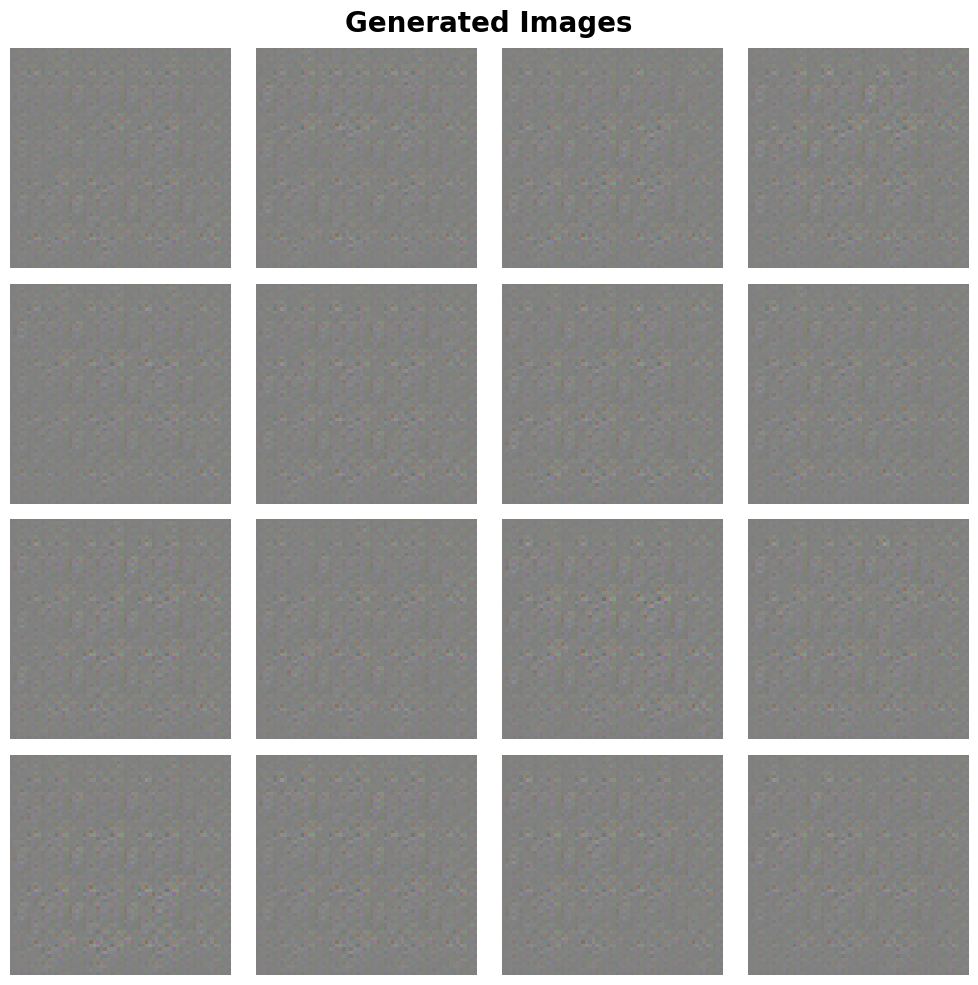

--------------------------------------------------


Epoch 2/20: 100%|██████████| 994/994 [01:04<00:00, 15.31it/s, D_loss=13.8523, G_loss=0.0000]


Epoch [2/20] - G_loss: 0.0000, D_loss: 13.2231

--- Generated Samples at Epoch 2 ---


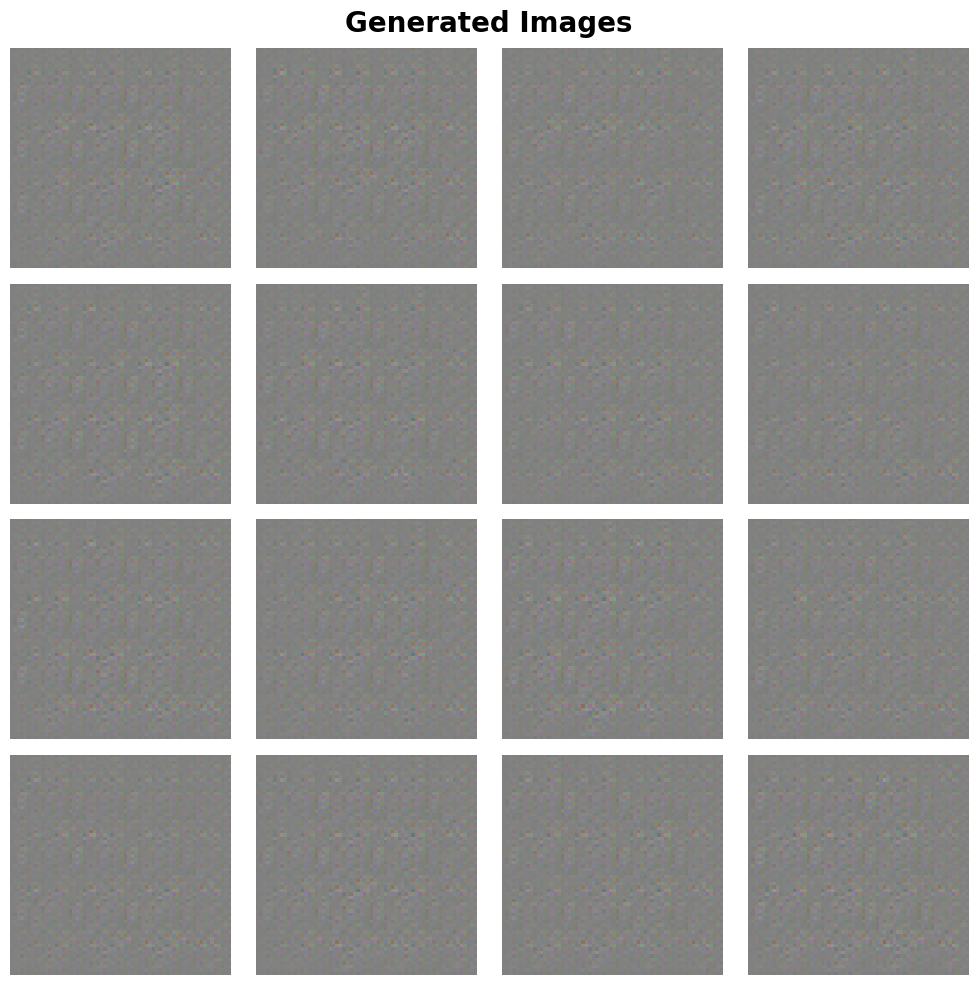

--------------------------------------------------


Epoch 3/20: 100%|██████████| 994/994 [01:07<00:00, 14.72it/s, D_loss=14.2965, G_loss=0.0000]


Epoch [3/20] - G_loss: 0.0000, D_loss: 13.9348

--- Generated Samples at Epoch 3 ---


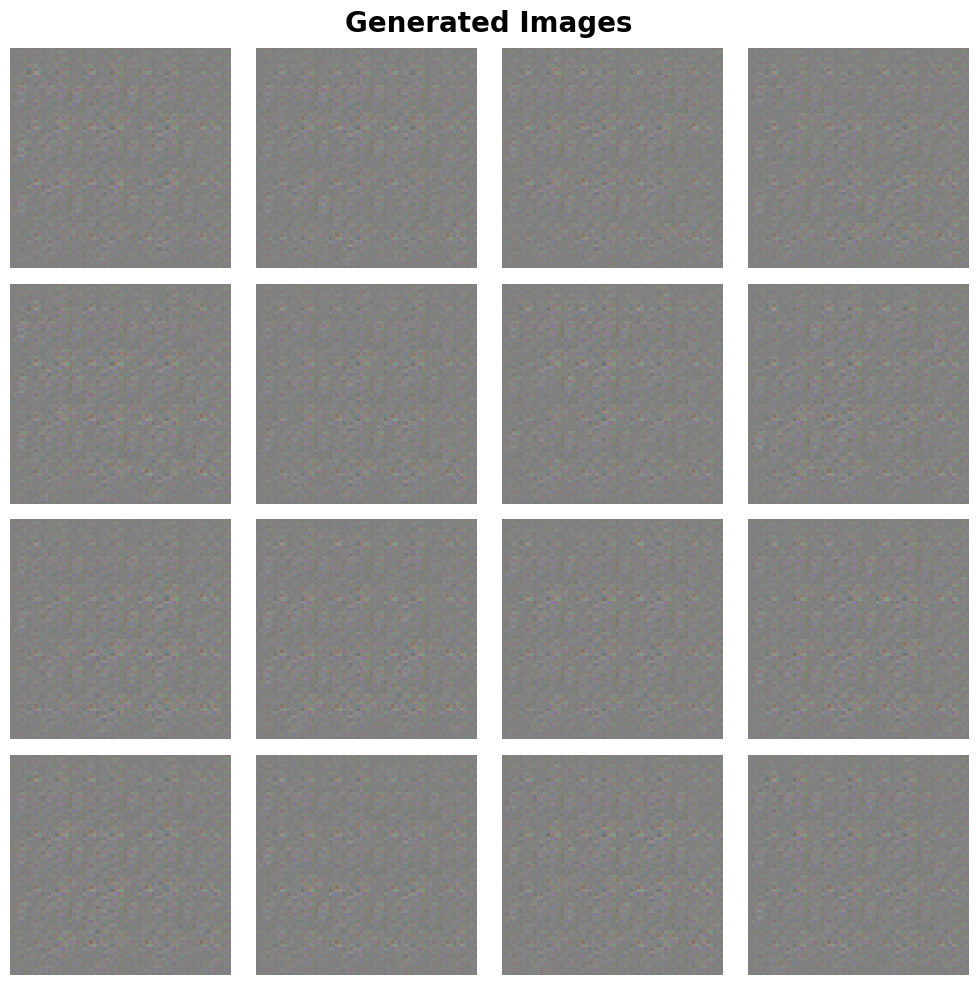

--------------------------------------------------


Epoch 4/20: 100%|██████████| 994/994 [01:10<00:00, 14.11it/s, D_loss=15.1775, G_loss=0.0000]


Epoch [4/20] - G_loss: 0.0000, D_loss: 14.6921

--- Generated Samples at Epoch 4 ---


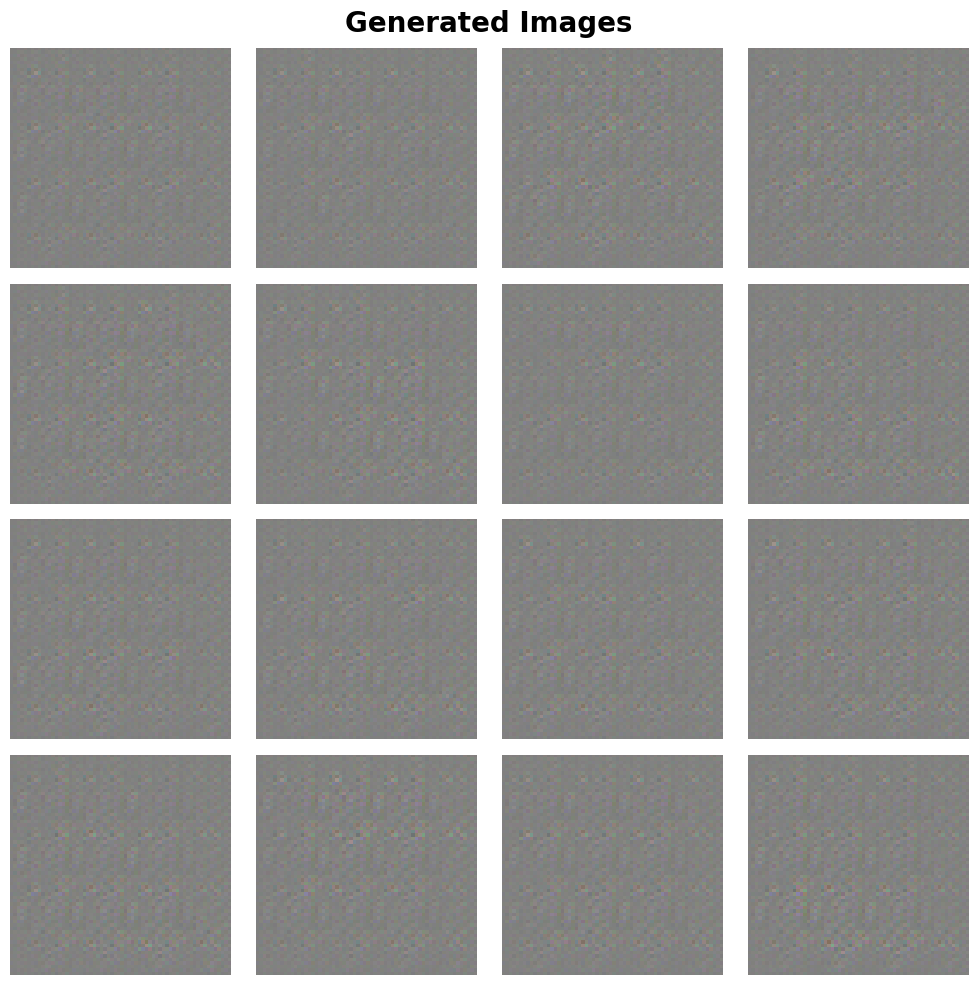

--------------------------------------------------


Epoch 5/20: 100%|██████████| 994/994 [01:13<00:00, 13.59it/s, D_loss=15.0306, G_loss=0.0000]


Epoch [5/20] - G_loss: 0.0000, D_loss: 15.9516

--- Generated Samples at Epoch 5 ---


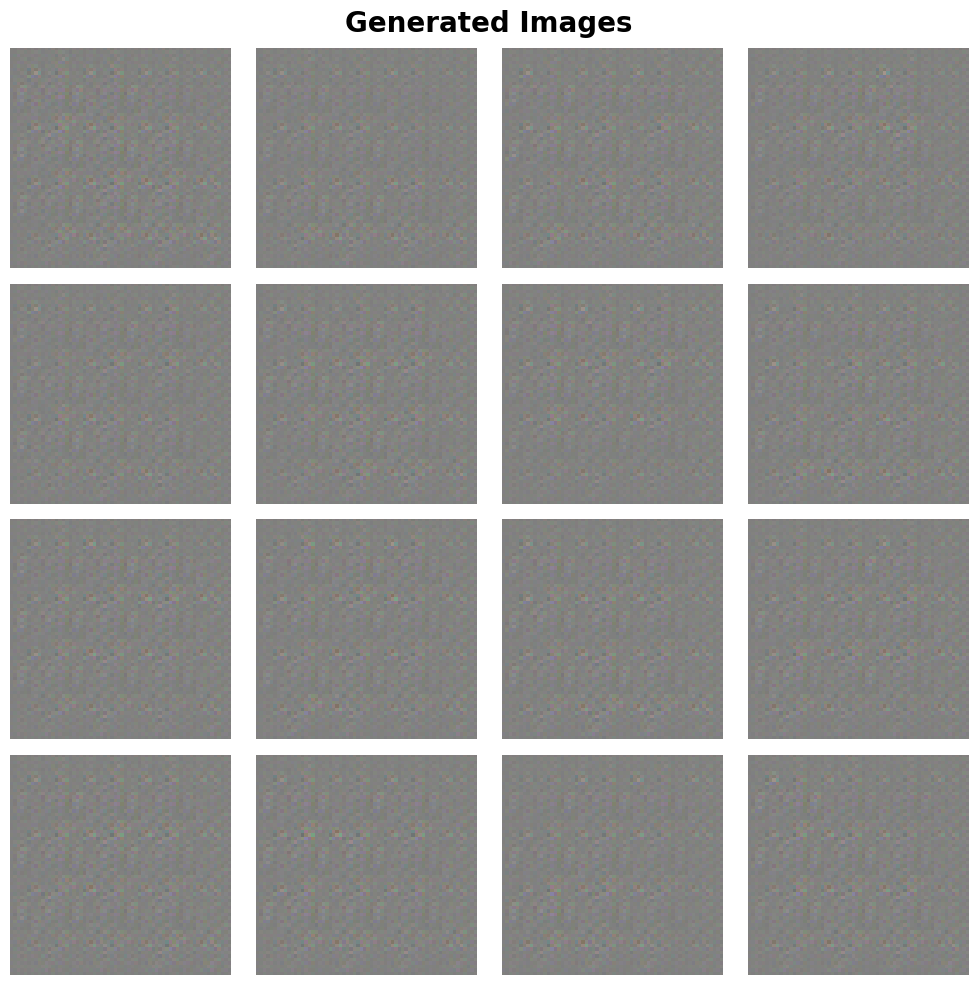

--------------------------------------------------


Epoch 6/20: 100%|██████████| 994/994 [01:18<00:00, 12.71it/s, D_loss=28.5802, G_loss=0.0000]


Epoch [6/20] - G_loss: 0.0000, D_loss: 19.0698

--- Generated Samples at Epoch 6 ---


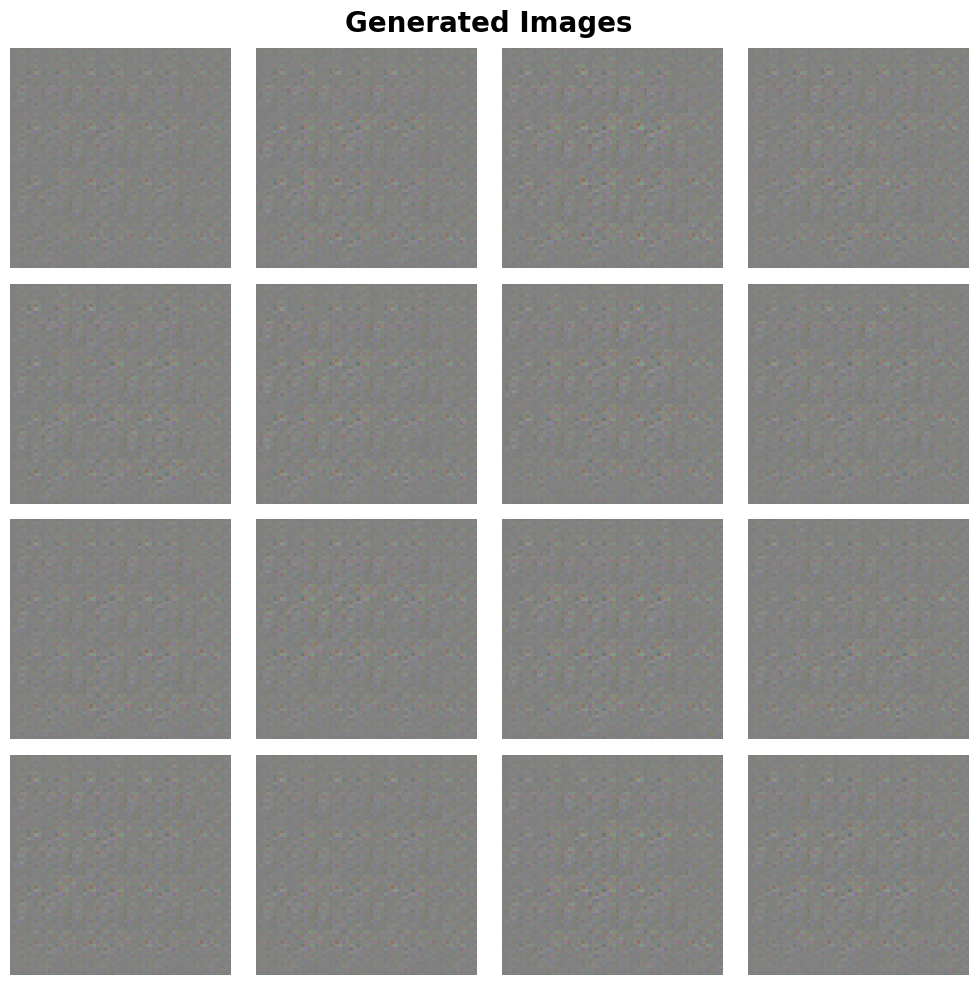

--------------------------------------------------


Epoch 7/20: 100%|██████████| 994/994 [01:14<00:00, 13.33it/s, D_loss=35.0464, G_loss=0.0000]


Epoch [7/20] - G_loss: 0.0000, D_loss: 26.0621

--- Generated Samples at Epoch 7 ---


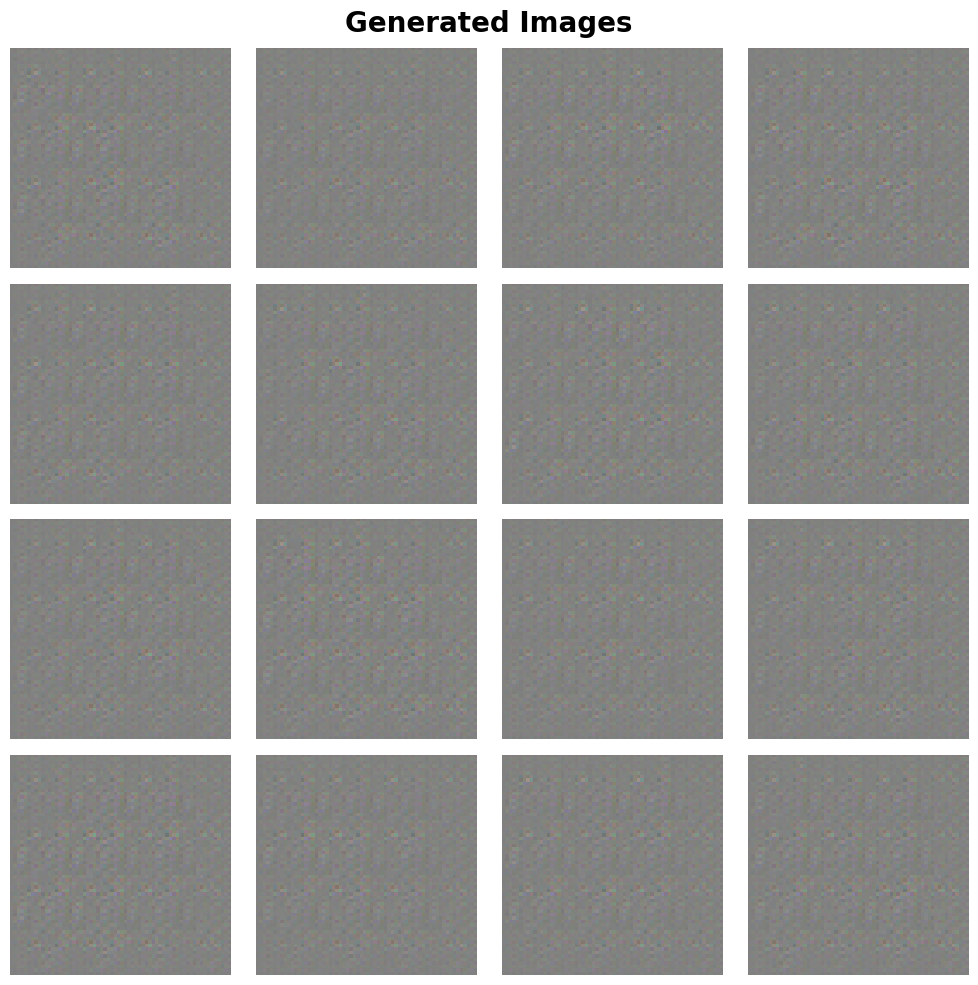

--------------------------------------------------


Epoch 8/20:  62%|██████▏   | 617/994 [00:47<00:27, 13.85it/s, D_loss=35.7757, G_loss=0.0000]

In [ ]:
print("Starting Anime Face GAN Training (PyTorch)!")
print(f"Training with {len(anime_dataset)} images for {EPOCHS} epochs using PyTorch.")

gen_losses, disc_losses = train_gan(
    train_dataloader, generator, discriminator,
    generator_optimizer, discriminator_optimizer, criterion,
    NOISE_DIM, fixed_noise, device
)

print("Training completed!")